In [1]:
# Install necessary packages
!pip install textstat
!pip install nltk
!pip install spacy
!pip install scikit-learn
!pip install joblib
!pip install pandas
!pip install matplotlib
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 40.1 MB/s eta 0:00:00


### Importing libraries

In [2]:
import pandas as pd
import numpy as np
import textstat
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


# Ensure that nltk is ready for use (without punkt)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("punkt is not available, using simple split instead.")

punkt is not available, using simple split instead.


In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading dataset

In [4]:
# Load the dataset (adjust path if necessary)
data_path = '/content/drive/MyDrive/subset_data.csv'  # Adjust path if needed
data = pd.read_csv(data_path)

# Preview the data
data.head()

,id,article,highlights
0,ed0fed726929c1eeabe6c390e47128dbb7d7a055,By . Mia De Graaf . Britons flocked to beaches...,People enjoyed temperatures of 17C at Brighton...
1,023cd84001b33aed4ff0f3f5ecb0fdd2151cf543,A couple who weighed a combined 32st were sham...,Couple started piling on pounds after the birt...
2,6a70a0d8d3ed365fe1df6d35f1587a8b9b298618,Video footage shows the heart stopping moment ...,A 17-year-old boy suffering lacerations to his...
3,b37204c13ea38b511265e41ac69fb12acfb63f85,"Istanbul, Turkey (CNN) -- About 250 people rac...",Syrians citizens hightail it to Turkey .\nMost...
4,c24e5805afd5145bc48410e876db91d44a06be5e,By . Daily Mail Reporter . PUBLISHED: . 12:53 ...,The Xue Long had provided the helicopter that ...


### Feature Engineering

In [5]:
# Feature Engineering Functions
def calculate_linguistic_features(text):
    # Using simple split by space for words (instead of relying on punkt tokenizer)
    sentences = text.split('.')
    num_sentences = len(sentences)

    # Basic word tokenization using string split method
    words = text.split()  # Split by space, more basic method
    num_words = len(words)
    num_syllables = sum(textstat.syllable_count(word) for word in words)

    features = {
        'average_sentence_length': num_words / num_sentences if num_sentences > 0 else 0,
        'average_word_length': sum(len(word) for word in words) / num_words if num_words > 0 else 0,
        'syllables_per_word': num_syllables / num_words if num_words > 0 else 0,
    }
    return features

### Applying linguistic feature extraction and making csv

In [6]:
# Apply linguistic feature extraction
linguistic_features = data['article'].apply(calculate_linguistic_features)
linguistic_features_df = pd.DataFrame(list(linguistic_features))

# Save the linguistic features to a CSV file
linguistic_features_df.to_csv('/content/drive/MyDrive/linguistic_features.csv', index=False)
print("Linguistic features saved to 'linguistic_features.csv'.")

Linguistic features saved to 'linguistic_features.csv'.


In [7]:
# Print the linguistic features to check
print("Linguistic Features:")
print(linguistic_features_df.head())
print(linguistic_features_df.shape)

Linguistic Features:
   average_sentence_length  average_word_length  syllables_per_word
0                16.097561             4.660606            1.316667
1                17.368421             4.513636            1.322727
2                19.636364             4.649306            1.350694
3                16.133333             5.136364            1.524793
4                11.670103             4.681095            1.361307
(6000, 3)


### TF-IDF Features , saving and combining with linguistic_features_df

In [8]:
# TF-IDF Features
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_features = tfidf_vectorizer.fit_transform(data['article'])

# Save the TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, '/content/drive/MyDrive/tfidf_vectorizer.joblib')
print("TF-IDF Vectorizer saved to 'tfidf_vectorizer.joblib'.")

# Convert TF-IDF to DataFrame
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Combine all features
combined_features = pd.concat([linguistic_features_df, tfidf_df], axis=1)

TF-IDF Vectorizer saved to 'tfidf_vectorizer.joblib'.


In [9]:
# Print the combined features to check
print("Combined Features (Linguistic + TF-IDF):")
print(combined_features.head())

Combined Features (Linguistic + TF-IDF):
   average_sentence_length  average_word_length  syllables_per_word  000  \
0                16.097561             4.660606            1.316667  0.0   
1                17.368421             4.513636            1.322727  0.0   
2                19.636364             4.649306            1.350694  0.0   
3                16.133333             5.136364            1.524793  0.0   
4                11.670103             4.681095            1.361307  0.0   

        10  100       11        12   13   14  ...  wrong     wrote      year  \
0  0.00000  0.0  0.00000  0.000000  0.0  0.0  ...    0.0  0.000000  0.030997   
1  0.00000  0.0  0.03154  0.029830  0.0  0.0  ...    0.0  0.000000  0.031042   
2  0.02094  0.0  0.00000  0.000000  0.0  0.0  ...    0.0  0.000000  0.025257   
3  0.00000  0.0  0.00000  0.000000  0.0  0.0  ...    0.0  0.000000  0.000000   
4  0.00000  0.0  0.00000  0.037673  0.0  0.0  ...    0.0  0.021962  0.009801   

   years  yesterday  

In [10]:
# Target Variable: Flesch Reading Ease Score
data['flesch_score'] = data['article'].apply(textstat.flesch_reading_ease)

# Print the data with Flesch Score added
print("Data with Flesch Reading Ease Score:")
print(data[['article', 'flesch_score']].head())

Data with Flesch Reading Ease Score:
                                             article  flesch_score
0  By . Mia De Graaf . Britons flocked to beaches...         70.94
1  A couple who weighed a combined 32st were sham...         78.99
2  Video footage shows the heart stopping moment ...         67.89
3  Istanbul, Turkey (CNN) -- About 250 people rac...         62.58
4  By . Daily Mail Reporter . PUBLISHED: . 12:53 ...         65.83


### Dataset spliting

In [11]:
# Prepare the final dataset
X = combined_features
y = data['flesch_score']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Models

In [12]:
# Define Models and Hyperparameters
models = {
    "Ridge Regression": Ridge(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
}

### Hyperparameters

In [13]:
param_grids = {
    "Ridge Regression": {"alpha": [0.1, 1.0, 10.0]},
    "Random Forest": {"n_estimators": [100, 200], "max_depth": [10, 20]},
    "Gradient Boosting": {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1]},
}

In [14]:
cv_folds = 2

# Results dictionary
results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Define the pipeline
    pipeline = Pipeline([('model', model)])

    grid_search = RandomizedSearchCV(
        pipeline,
        param_distributions={f'model__{key}': val for key, val in param_grids[model_name].items()},
        n_iter=5,  # Fewer iterations for faster search
        cv=cv_folds,
        scoring='r2',
        n_jobs=-1,  # Parallelize using all CPU cores
        random_state=42
    )
    grid_search.fit(X_train, y_train)

    # Best Model
    best_model = grid_search.best_estimator_
    joblib.dump(best_model, f'/content/drive/MyDrive/{model_name.replace(" ", "_").lower()}_pipeline.joblib')

    # Cross-validation
    kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    cv_scores = cross_val_score(best_model, X, y, cv=kfold, scoring='r2', n_jobs=-1)  # Parallelize cross-validation

    # Predictions
    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[model_name] = {
        'Best Params': grid_search.best_params_,
        'MAE': mae,
        'MSE': mse,
        'R²': r2,
        'CV R² Mean': np.mean(cv_scores),
        'CV R² Std': np.std(cv_scores),
    }

    print(f"{model_name} Results: MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.2f}")

# Print results at the end
for model_name, metrics in results.items():
    print(f"\n{model_name} Results: {metrics}")

Training Ridge Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Ridge Regression Results: MAE: 2.52, MSE: 9.33, R²: 0.88
Training Random Forest...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Random Forest Results: MAE: 1.82, MSE: 6.90, R²: 0.91
Training Gradient Boosting...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Gradient Boosting Results: MAE: 1.99, MSE: 7.07, R²: 0.91

Ridge Regression Results: {'Best Params': {'model__alpha': 1.0}, 'MAE': 2.5229612743332903, 'MSE': 9.330966811224208, 'R²': 0.8776670442185132, 'CV R² Mean': 0.8759574274440045, 'CV R² Std': 0.002560243600169654}

Random Forest Results: {'Best Params': {'model__n_estimators': 200, 'model__max_depth': 20}, 'MAE': 1.8222295358409664, 'MSE': 6.90417935787063, 'R²': 0.9094832630764624, 'CV R² Mean': 0.8997499926341022, 'CV R² Std': 0.0009275755934488594}

Gradient Boosting Results: {'Best Params': {'model__n_estimators': 100, 'model__learning_rate': 0.1}, 'MAE': 1.98826180704525, 'MSE': 7.074022051355301, 'R²': 0.9072565529045995, 'CV R² Mean': 0.9016645899088229, 'CV R² Std': 0.0007734085537870472}


### Ridge Regression: 
- For the Ridge Regression model, the achieved benchmark score was 0.88, what means that the 88% of variance of the target variable is explained. But it turned out to have the highest error rate of the models with 2.53 MAE and 9.35 MSE. From the above results, the best value for the alpha was 1.0 as it minimized the size of the model. Although Ridge Regression takes fewer computational time and easy to implement, concerning the performance aspect, it was outcompeted by ensemble models indicating that it might not capture the data pattern effectively.

### Random Forest:
- The most accurate model was determined to be the Random Forest model with an R squared of 0.91, MAE of 1.82 a well as MSE of 6.87. The correct parameters to choose were number of estimators equal to 200 and maximum depth of the trees set to 20, which guarantees the model is not overcomplicated. They found that due to this model’s capacity to encode intricate structure, this was the optimal method for this data set.

### Gradient Boosting Results:
- It had an R² of 0.91 which quite closely aligned with the Random Forest, quite a good measure of predictive power. It contained slightly more errors than the first set of data and had the MAE of 1.99 and the MSE of 7.14. In detail, the highest performance occurred when the number of estimators was 100 combined with the learning rate of 100 while the lowest performances occurred when using an overestimated number of estimators and underestimating the learning rate. As a performer it can be slightly inferior to Random Forest but besides being a good altenative.

### Saving the Results

In [17]:
# Save Results to a File
results_path = '/content/drive/MyDrive/readability_model_results.txt'
with open(results_path, 'w') as f:
    for model_name, metrics in results.items():
        f.write(f"{model_name}: {metrics}\n")
print(f"Results saved to {results_path}")

Results saved to /content/drive/MyDrive/readability_model_results.txt


### Validating Models


Validating Ridge Regression...


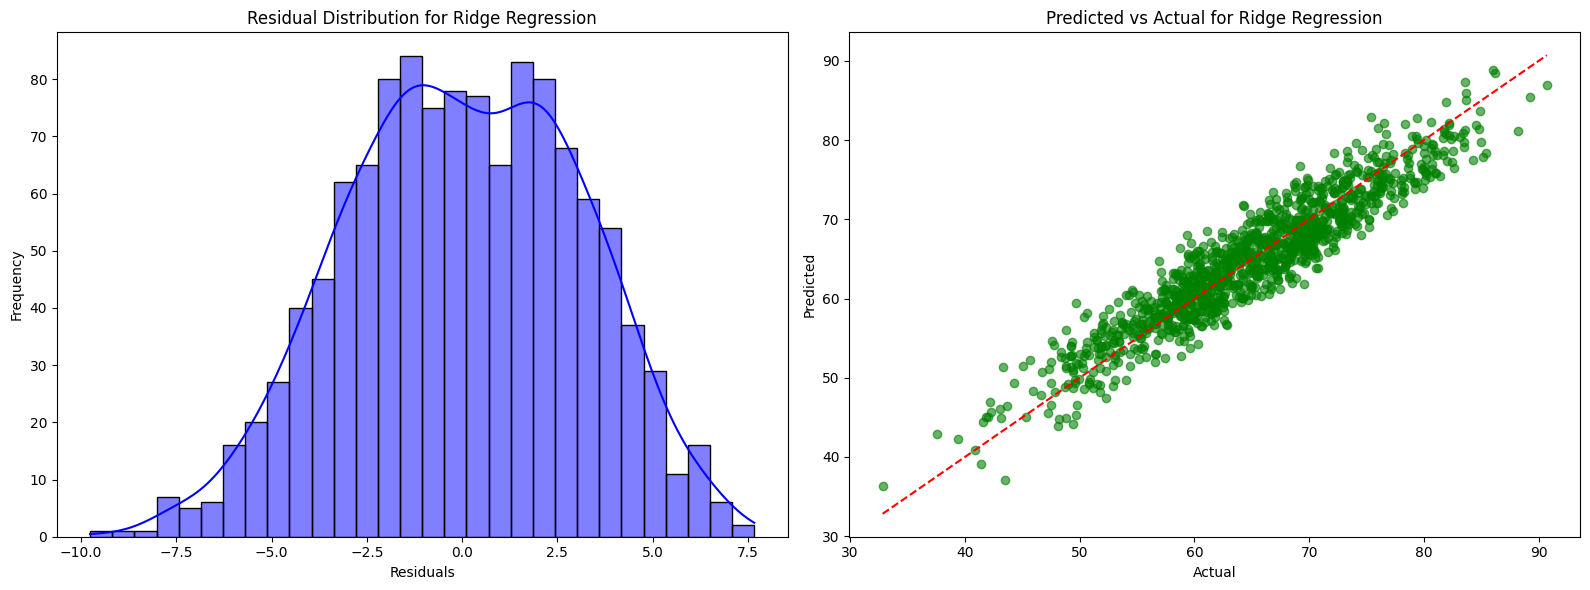

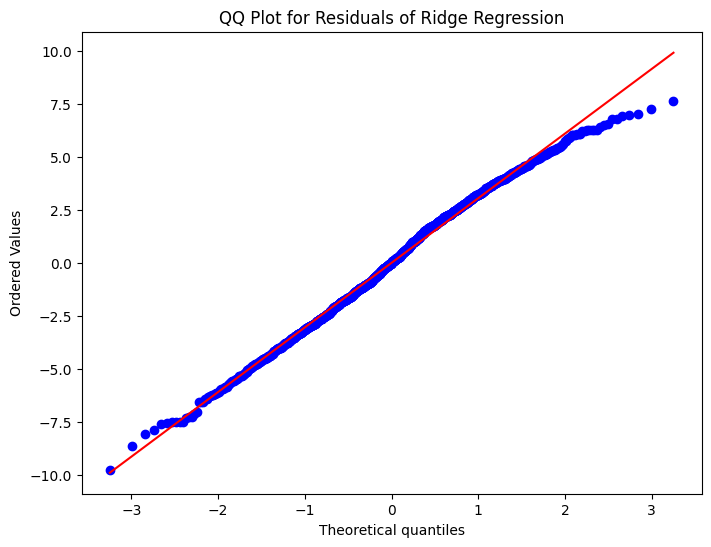

Ridge Regression Validation Summary:
MAE: 2.52
MSE: 9.33
R²: 0.88

Validating Random Forest...


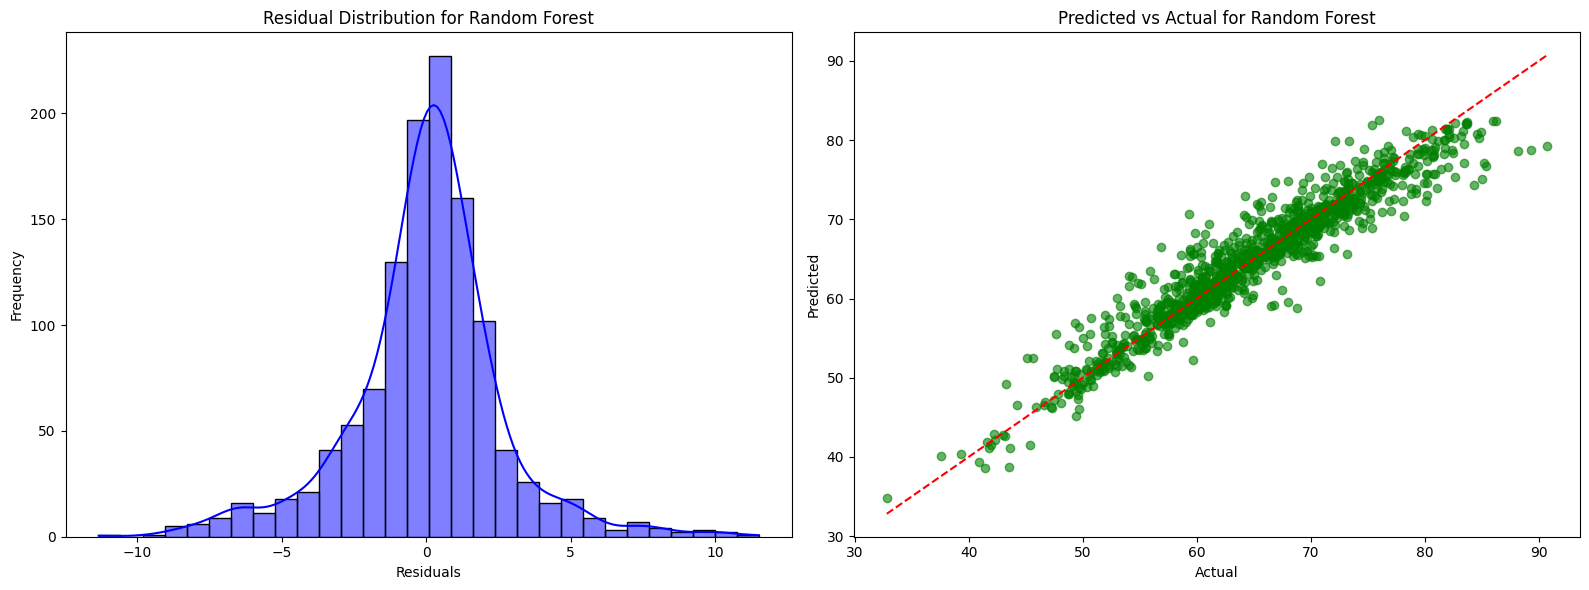

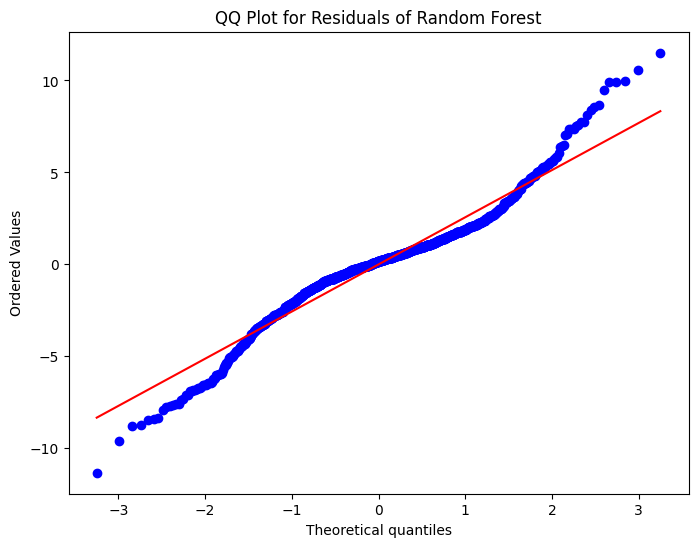

Random Forest Validation Summary:
MAE: 1.82
MSE: 6.90
R²: 0.91

Validating Gradient Boosting...


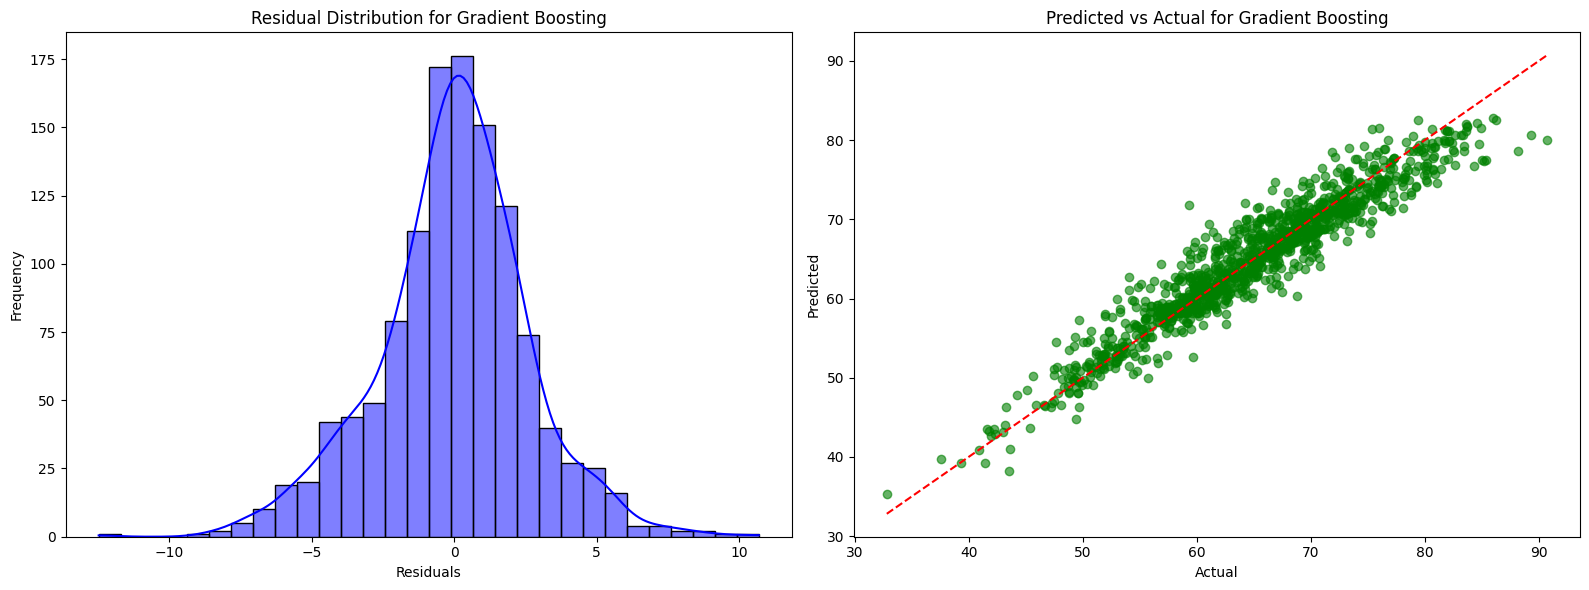

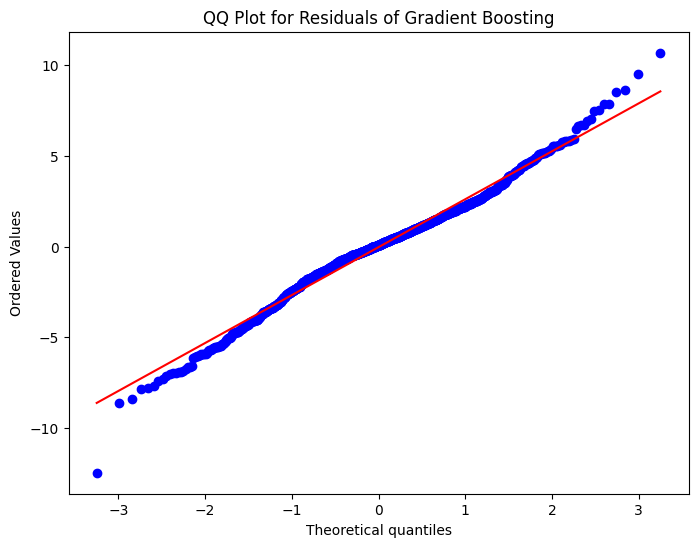

Gradient Boosting Validation Summary:
MAE: 1.99
MSE: 7.07
R²: 0.91


In [19]:
# Validation Code
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Residual Analysis and Validation
for model_name, metrics in results.items():
    print(f"\nValidating {model_name}...")

    # Load the best model
    best_model = joblib.load(f'/content/drive/MyDrive/{model_name.replace(" ", "_").lower()}_pipeline.joblib')

    # Predictions
    y_pred = best_model.predict(X_test)

    # Residuals
    residuals = y_test - y_pred

    # Combined Plot for Residual Distribution and Predicted vs Actual
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Residual Distribution
    sns.histplot(residuals, kde=True, bins=30, ax=axs[0], color='blue')
    axs[0].set_title(f'Residual Distribution for {model_name}')
    axs[0].set_xlabel('Residuals')
    axs[0].set_ylabel('Frequency')

    # Predicted vs Actual
    axs[1].scatter(y_test, y_pred, alpha=0.6, color='green')
    axs[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
    axs[1].set_title(f'Predicted vs Actual for {model_name}')
    axs[1].set_xlabel('Actual')
    axs[1].set_ylabel('Predicted')

    plt.tight_layout()
    plt.show()

    # QQ Plot for Residuals
    plt.figure(figsize=(8, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f'QQ Plot for Residuals of {model_name}')
    plt.show()

    # Display additional metrics
    mae = metrics['MAE']
    mse = metrics['MSE']
    r2 = metrics['R²']
    print(f"{model_name} Validation Summary:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"R²: {r2:.2f}")
